In [5]:
# Load Data
import pandas as pd
petitions_2020fy = pd.read_csv(r'data/petitions_fiscal_year_2020.csv', parse_dates = ['month_commencing'])
petitions_2020fy.dtypes # Check dtypes

full_text                   object
topics                      object
month_commencing    datetime64[ns]
dtype: object

In [6]:
# Apply preprocessing and generate global dictionary from whole corpus
import spacy
from scripts.functions.utils import ChainerCleanList
from scripts.functions.text_cleaning import standardize_whitespace, expand_contractions
from scripts.functions.spacy_utils import SpacyGensimBOW

preproc = ChainerCleanList(
    standardize_whitespace, # Cleans additional whitespace from text, leaving only sngle spaces between symbols
    expand_contractions # Searches for contractions, such as "'ll", and expands them, i.e. to " will"
)

nlp = spacy.load('en_core_web_sm') # pre-trained pipeline from spacy
preprocessor = SpacyGensimBOW(
    nlp, 
    preproc_function = preproc, 
    stop_words = True, # default stop word list from spacy applied
    ner = None, # default NER searching protocal (finds quantities and organizations, removes symbols/punctuation)
    lemmatize = True # tokens lemmatized
)

petitions_2020fy['text_bow'] = preprocessor(petitions_2020fy['full_text']) # ~15min runtime
# tokenized texts extracted for coherence scores:
petitions_2020fy['tokenized_text'] = preprocessor.texts

In [7]:
# Set up text vectorizer: term frequency - inverse document frequency
from gensim.models import TfidfModel
tfidf = TfidfModel(id2word = preprocessor.dictionary, smartirs = 'ltc') # currently untrained

In [8]:
# Set up HDP model's initial arguments
from gensim.models import HdpModel
hdp_init = dict(
    id2word = preprocessor.dictionary, 
    chunksize = 512, 
    K = 10, 
    T = 500, 
    random_state = 42, 
    alpha = 0.1,
    gamma = 2
)

# Get coherence model
from gensim.models.coherencemodel import CoherenceModel

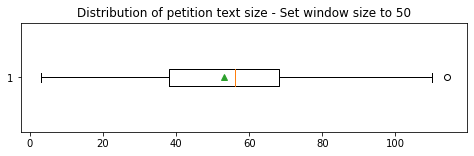

In [9]:
# import matplotlib to build visuals for topic key terms and to inform window size of CoherenceModel
import matplotlib.pyplot as plt
import numpy as np

# Investigate distribution of petition token sizes
fig, ax = plt.subplots(figsize = (8, 2))
title = 'Distribution of petition text size - Set window size to 50'
ax.set_title(title)
ax.boxplot(
    x = petitions_2020fy['tokenized_text'].apply(lambda el : len(el)),
    vert = False, 
    showmeans = True
)

fig.savefig(f'figures/{title.replace(" ", "_")}.png')

Handling month: 2020-04-01
Initializing Hierarchical Dirichlet Process...
Number of topics derived in training session: 197
Assess hdp models topic coherence scores... (This takes a long time)
Coherence u_mass score: -7.366780270263883
Unique topics in hold out: 2
Handling month: 2020-05-01
Updating Hierarchical Dirichlet Process...
Number of topics derived in training session: 30
Assess hdp models topic coherence scores... (This takes a long time)
Coherence u_mass score: -8.857546558760289
Unique topics in hold out: 2
Handling month: 2020-06-01
Updating Hierarchical Dirichlet Process...
Number of topics derived in training session: 9
Assess hdp models topic coherence scores... (This takes a long time)
Coherence u_mass score: -10.874336000829109
Unique topics in hold out: 2
Handling month: 2020-07-01
Updating Hierarchical Dirichlet Process...
Number of topics derived in training session: 3
Assess hdp models topic coherence scores... (This takes a long time)
Coherence u_mass score: -12.

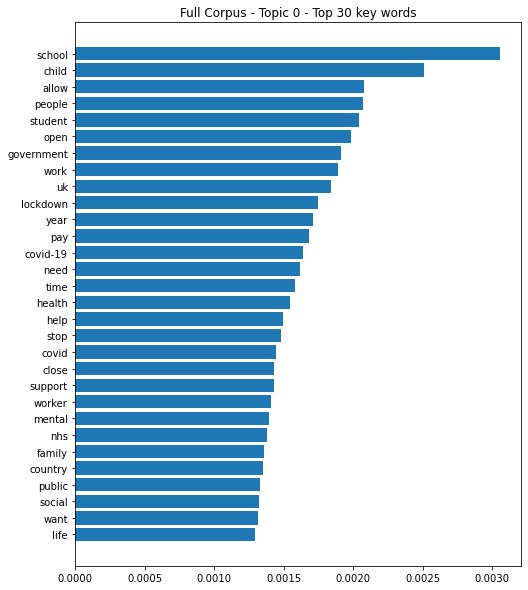

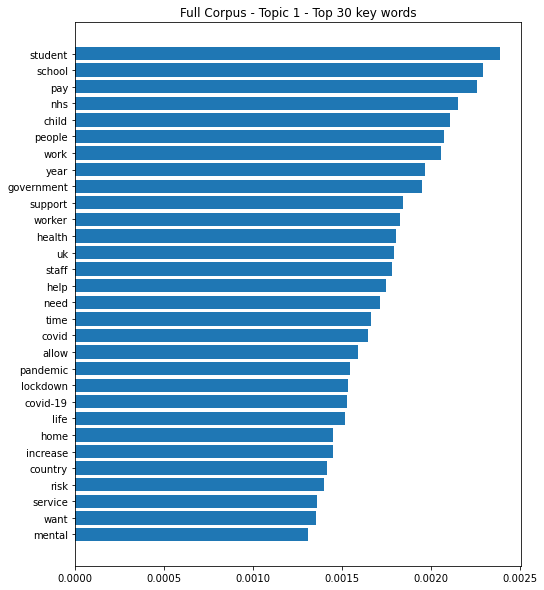

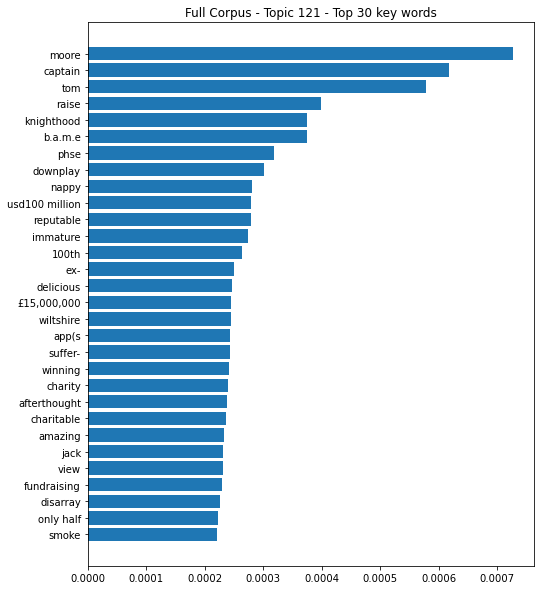

In [10]:
# Prepare hold out holder documents
hold_outs = pd.DataFrame()
# Prepare common corpus for coherence model
common_tfidf = []
# prepare to record how number of topics evolve
num_topics = []
# prepare to record number of topics assigned in each hold out set
hold_out_num_topics = []
# Prepare coherence scores
coherence_scores = []

# loop through each month to update hdp model
# Unique months to cycle through
months = sorted(petitions_2020fy['month_commencing'].unique())
for single_month in months:
    print(f'Handling month: {np.datetime_as_string(single_month, unit = "D")}')

    # Extract single month corpus and tokenized texts for all previous months
    month_corpus = petitions_2020fy.loc[
        petitions_2020fy['month_commencing'] == single_month, 
        'text_bow'
    ]

    leq_tokenized = petitions_2020fy.loc[
        petitions_2020fy['month_commencing'] <= single_month, 
        'tokenized_text'
    ]

    # Hold out 5 documents for each month to test classifications on:
    hold_out_corpus = month_corpus.sample(n = 5, random_state = 16)

    # Remove hold_out_corpus from month_corpus
    month_corpus.drop(index = hold_out_corpus.index, inplace = True)


    # Remove hold_out_corpus from month_corpus
    leq_tokenized.drop(
        index = hold_outs.index.union(hold_out_corpus.index), 
        inplace = True
    )


    # Get full text from hold_out_corpus
    hold_out_df = petitions_2020fy.loc[hold_out_corpus.index].copy()
    
    # Apply tfidf and hdp to month_corpus
    month_corpus_list = month_corpus.to_list()
    # tfidf
    tfidf.initialize(month_corpus_list)
    month_tfidf = tfidf[month_corpus_list]
    common_tfidf.extend(list(month_tfidf)) # update common_tfidf

    # hdp
    if 'hdp' not in globals():
        print('Initializing Hierarchical Dirichlet Process...')
        hdp = HdpModel(
            corpus = month_tfidf,
            **hdp_init
        )
    else:
        print('Updating Hierarchical Dirichlet Process...')
        hdp.update(month_tfidf)

    month_hdp = hdp[month_tfidf]

    # update number of topics derived in updated training session
    unique_topics = len({i[0] for j in month_hdp for i in j})
    print(f'Number of topics derived in training session: {unique_topics}')
    num_topics.append(unique_topics) # update to num_topics
    
    print('Assess hdp models topic coherence scores... (This takes a long time)')
    # Set up coherence model to get coherence score
    coherence = CoherenceModel(
        model = hdp, 
        texts = leq_tokenized, 
        corpus = common_tfidf, 
        window_size = 50,
        coherence = 'u_mass',
        processes = 1
    )

    score_coherence = coherence.get_coherence()
    print(f'Coherence u_mass score: {score_coherence}')
    coherence_scores.append(score_coherence)

    # Apply hold out texts to hdp
    hold_out_hdp = list(hdp[tfidf[hold_out_corpus]])
    hold_out_df['topic_classification'] = hold_out_hdp

    # Get top 30 words for topic documents in hold out to validate against
    unique_topics = {i[0] for j in hold_out_hdp for i in j}
    print(f'Unique topics in hold out: {len(unique_topics)}')
    hold_out_num_topics.append(len(unique_topics)) # update hold_out_num_topics
    topic_terms = dict()
    for topic_id in unique_topics:
        topic_terms[topic_id] = dict(
            hdp.show_topic(
                topic_id, 
                topn = 30
            )
        )
    
    # Generate visuals for each topic assigned to hold out corpus
    for topic_no in topic_terms.keys():

        y = list(topic_terms[topic_no].keys())
        y.reverse()
        x = list(topic_terms[topic_no].values())
        x.reverse()

        vis_title = f'{np.datetime_as_string(single_month, unit = "D")} - Topic {topic_no} - Top 30 key words'
        fig, ax = plt.subplots(figsize = (8, 10))
        ax.set_title(vis_title)
        ax.barh(y, x)

        fig.savefig(f'figures/{vis_title.replace(" ", "_")}.png')
        plt.close()
        
    # Add hold out documents to list of hold outs
    hold_outs = pd.concat([hold_outs, hold_out_df])
    
# Get top 30 words for topic documents in full dataset
unique_topics = {i[0] for j in hdp[common_tfidf] for i in j}
print(f'Unique topics accross all petitions: {len(unique_topics)}')
topic_terms = dict()
for topic_id in unique_topics:
    topic_terms[topic_id] = dict(
        hdp.show_topic(
            topic_id, 
            topn = 30
        )
    )

# Generate visuals for each topic assigned to hold out corpus
for topic_no in topic_terms.keys():

    y = list(topic_terms[topic_no].keys())
    y.reverse()
    x = list(topic_terms[topic_no].values())
    x.reverse()

    vis_title = f'Full Corpus - Topic {topic_no} - Top 30 key words'
    fig, ax = plt.subplots(figsize = (8, 10))
    ax.set_title(vis_title)
    ax.barh(y, x)

    fig.savefig(f'figures/{vis_title.replace(" ", "_")}.png')

# Save hould outs to review later
hold_outs.to_csv(f'figures/hold_outs_df.csv', index = False)

In [11]:
full_vocab = set()
for tup in petitions_2020fy.itertuples(index = False, name = 'Petition'):
    full_vocab.update(set(tup.tokenized_text))

print(f'Number of unique corpus tokens: {len(full_vocab)}')

Number of unique corpus tokens: 28768


In [ ]:
vis_title = f'Number of topics assigned to petitions at each training step'
fig, ax = plt.subplots(figsize = (20, 10))
ax.set_title(vis_title)
ax.plot(sorted(months), num_topics)

fig.savefig(f'figures/{vis_title}.png')
plt.close()

vis_title = f'u_mass scores of models at each training step'
fig, ax = plt.subplots(figsize = (20, 10))
ax.set_title(vis_title)
ax.plot(sorted(months), coherence_scores)

fig.savefig(f'figures/{vis_title}.png')
plt.close()

pd.DataFrame(
    [list(el) for el in zip(sorted(months), num_topics, hold_out_num_topics, coherence_scores)], 
    columns=['Month Commncing', 'Number of Topics', 'Number of Topics - Hold out', 'U_mass Model Score']
).to_csv(f'figures/{vis_title}.csv', index = False)